Found 20638 files belonging to 15 classes.
Using 4127 files for validation.
Classification report:
                                             precision    recall  f1-score   support

              Pepper__bell___Bacterial_spot       0.98      1.00      0.99       200
                     Pepper__bell___healthy       1.00      0.98      0.99       302
                      Potato___Early_blight       0.99      0.99      0.99       189
                       Potato___Late_blight       0.94      0.97      0.96       188
                           Potato___healthy       0.83      0.97      0.90        31
                      Tomato_Bacterial_spot       0.96      0.97      0.96       441
                        Tomato_Early_blight       0.96      0.71      0.81       191
                         Tomato_Late_blight       0.93      0.96      0.94       341
                           Tomato_Leaf_Mold       0.98      0.91      0.95       185
                  Tomato_Septoria_leaf_spot       

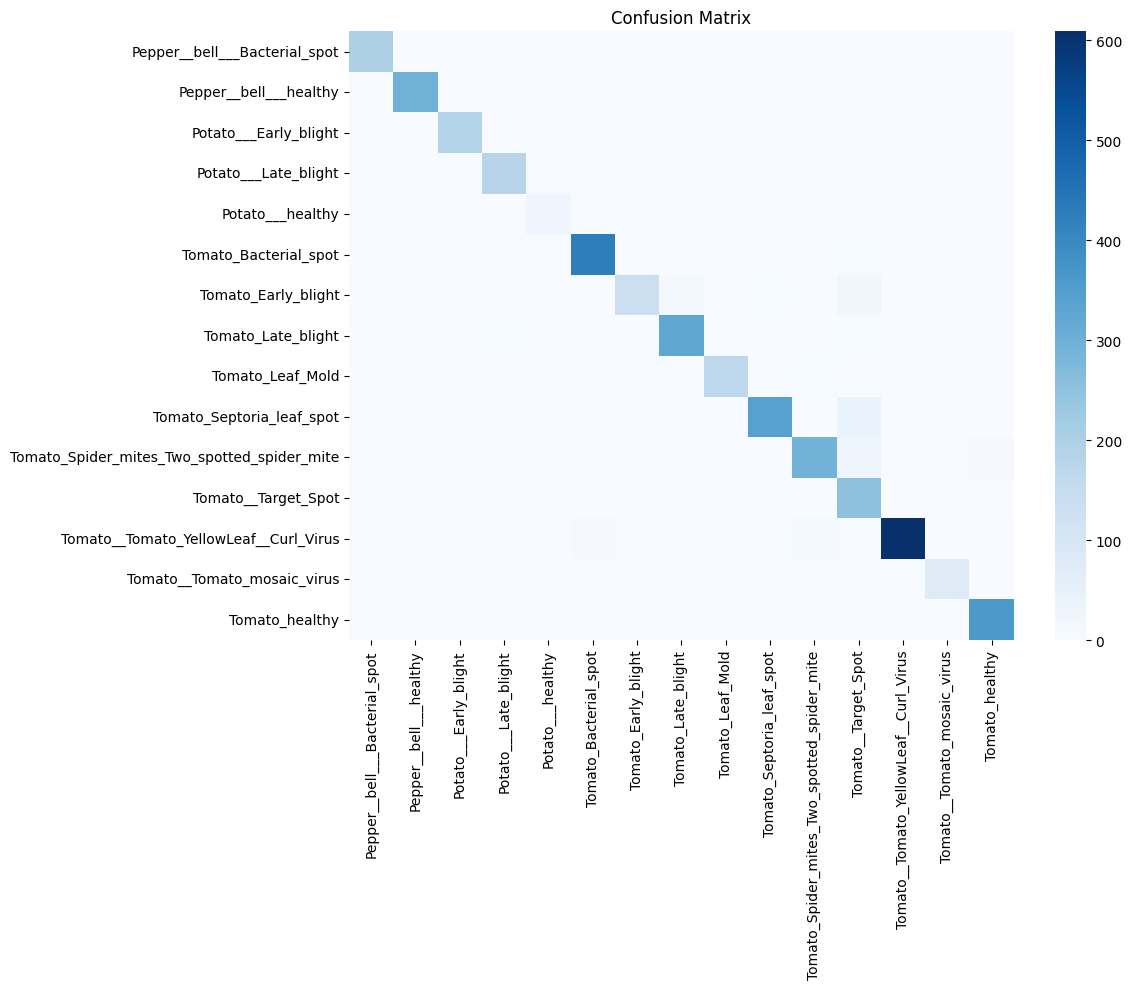

Saved per class metrics CSV.


In [1]:
# 04_Model_Evaluation.py
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pathlib
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix

PROJECT_ROOT = pathlib.Path("..")
MODELS_DIR = PROJECT_ROOT / "models" / "leafnet_v1"
DATA_DIR = PROJECT_ROOT / "data" / "raw" / "PlantVillage"
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# Load class names
with open(PROJECT_ROOT / "models" / "class_names.json", "r", encoding="utf-8") as f:
    class_names = json.load(f)

# Load model
model = tf.keras.models.load_model(str(MODELS_DIR / "saved_model"))

# Prepare validation dataset (make sure it's identical to training split)
val_ds = tf.keras.utils.image_dataset_from_directory(
    str(DATA_DIR),
    validation_split=0.2,
    subset="validation",
    seed=42,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

# Collect predictions and true labels
y_true = []
y_pred = []
probs = []

for imgs, labels in val_ds.unbatch().batch(64):
    preds = model.predict(imgs, verbose=0)
    pred_idx = np.argmax(preds, axis=1)
    y_true.extend(labels.numpy().tolist())
    y_pred.extend(pred_idx.tolist())
    probs.extend(preds.tolist())

y_true = np.array(y_true)
y_pred = np.array(y_pred)

print("Classification report:")
print(classification_report(y_true, y_pred, target_names=class_names, zero_division=0))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=False, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.title("Confusion Matrix")
plt.tight_layout()
plt.savefig(str(MODELS_DIR / "confusion_matrix.png"))
plt.show()

# Save a small CSV of per-class metrics
from sklearn.metrics import precision_recall_fscore_support
p, r, f1, sup = precision_recall_fscore_support(y_true, y_pred, zero_division=0)
import pandas as pd
df = pd.DataFrame({
    "class": class_names,
    "precision": p,
    "recall": r,
    "f1": f1,
    "support": sup
})
df.to_csv(str(MODELS_DIR / "per_class_metrics.csv"), index=False)
print("Saved per class metrics CSV.")
